# Movie Recommendation System
#### Bokšić Iva, Čubek Matej, Grbeša Tomislav
### Stvaranje prediktivnog modela preporuke filma pomoću MovieLens dataseta.


Cilj je eksploratorna analiza te razvijanje prediktivnog modela preporuke filma algoritmima strojnog učenja pomoću MovieLens dataseta.
Model bi preporučivao nove filmove korisniku s obzirom na podatke koje ima o korisniku
kao što su koje žanrove preferira, koje filmove je dobro ocijenio te koje loše  te s obzirom na
podatke vrlo sličnih korisnika.

[MovieLens dataset](https://grouplens.org/datasets/movielens/)

U demonstraciji koristimo minimalnu verziju dataseta "ml-latest-small" i "ml-latest"

## Analiza podataka

In [9]:
#Import paketa

from math import sqrt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import itertools
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Više izlaznih linija
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Dataset sadrži podatke o filmovima u movies.csv-u.

Svaki film sadrži svoj ID "_movieId_", naslov "_title_". Stupac "_genres_" sadrži
žanrove pojedinog filma koji su spojeni u jedan string i međusobno odvojeni znakom "|".

In [4]:
#Učitana csv file vezan za informacije o filmovima
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Broj filmova u datasetu.

In [3]:
movies['movieId'].count()


9742

Podaci o ocjenjivanju iz ratings.csv sadrže ID korisnika "_userId_" koji je pogledao film "_movieId_" i ocijenio ga s
ocjenom prikazanom u "_rating_".


In [5]:
#Učitan csv file vezan za ocijenjivanje filmova
ratings = pd.read_csv('ml-latest-small/ratings.csv',usecols=['userId','movieId','rating'])
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Komentari korisnika o pojedinom filmu nalaze se u tags.csv-u. Korisnik s ID-om "_userId_" za film s ID-om "_movieId_"
ostavio je komentar "_tag_".

In [5]:
tags=pd.read_csv('ml-latest-small/tags.csv',usecols=['userId','movieId','tag'])
tags.head()


,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


Statistika o ocjenama filmova.

In [6]:
ratings['rating'].describe(include='all')


count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

**Histogram ocjena**

Histogram prikazuje koliko je filmova ocijenjeno kojom ocjenom.
Najviše filmova ima ocjenu između 3 i 4.

rating
0.5    1066
1.0    1726
1.5    1386
2.0    3339
2.5    2925
3.0    4986
3.5    4216
4.0    5109
4.5    2710
5.0    2954
Name: movieId, dtype: int64

array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

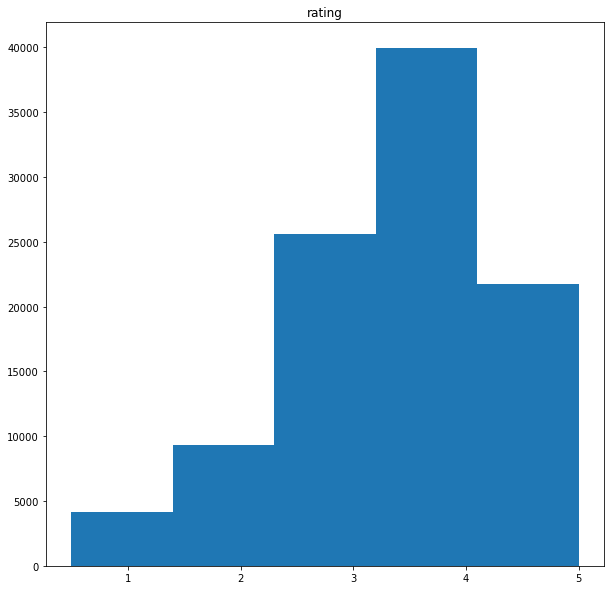

In [7]:
ratings.groupby('rating')['movieId'].nunique()

ratings.hist(column='rating',figsize=(10,10),bins=5,grid=False)

Izbacivanje filmova bez žanra i ispis broja filmova po žanru.

Budući da su žanrovi spojeni u jedan string potrebno ih je razdvojiti i proći po svima kako bi se zabilježilo koji se sve
žanrovi pojavljuju i koliko puta.

In [8]:
genre_filter = (movies['genres'] == '(no genres listed)')

movies_filtre = movies[~genre_filter]
movies_filtre=movies_filtre.reset_index(drop=True)

genres_count = {}
for row in range(movies_filtre['movieId'].count()):
    for genre in movies_filtre['genres'][row].split("|"):
        if genre!='':
            genres_count[genre]=genres_count.get(genre,0)+1

genres_count

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87}

**Histogram žanr**

Histogram prikazuje zastupljenost žanrova u svim filmovima. Drama se ispostavila kao najzastupljeniji žanr.

<BarContainer object of 19 artists>

([<matplotlib.axis.YTick at 0x2b3f503ddc0>,
 [Text(0, 0, 'Adventure'),
  Text(0, 1, 'Animation'),
  Text(0, 2, 'Children'),
  Text(0, 3, 'Comedy'),
  Text(0, 4, 'Fantasy'),
  Text(0, 5, 'Romance'),
  Text(0, 6, 'Drama'),
  Text(0, 7, 'Action'),
  Text(0, 8, 'Crime'),
  Text(0, 9, 'Thriller'),
  Text(0, 10, 'Horror'),
  Text(0, 11, 'Mystery'),
  Text(0, 12, 'Sci-Fi'),
  Text(0, 13, 'War'),
  Text(0, 14, 'Musical'),
  Text(0, 15, 'Documentary'),
  Text(0, 16, 'IMAX'),
  Text(0, 17, 'Western'),
  Text(0, 18, 'Film-Noir')])

Text(0.5, 0, 'Broj Filmova')

Text(0.5, 1.0, 'Popularnost žanrova')

Text(1283, 0.1, '1263')

Text(631, 1.1, '611')

Text(684, 2.1, '664')

Text(3776, 3.1, '3756')

Text(799, 4.1, '779')

Text(1616, 5.1, '1596')

Text(4381, 6.1, '4361')

Text(1848, 7.1, '1828')

Text(1219, 8.1, '1199')

Text(1914, 9.1, '1894')

Text(998, 10.1, '978')

Text(593, 11.1, '573')

Text(1000, 12.1, '980')

Text(402, 13.1, '382')

Text(354, 14.1, '334')

Text(460, 15.1, '440')

Text(178, 16.1, '158')

Text(187, 17.1, '167')

Text(107, 18.1, '87')

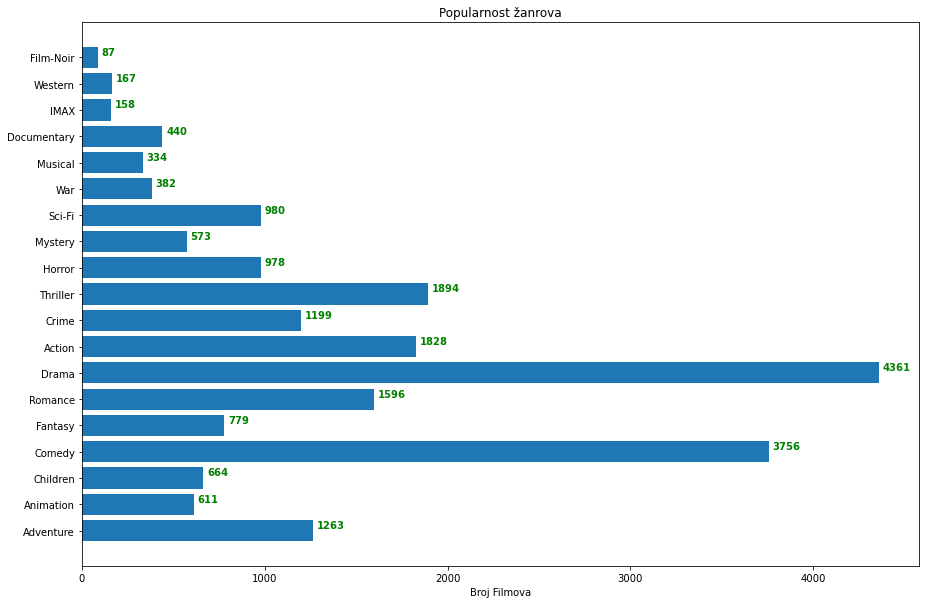

In [9]:
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(range(len(genres_count)),genres_count.values())
plt.yticks(range(len(genres_count)),list(genres_count.keys()))
plt.xlabel('Broj Filmova')
plt.title("Popularnost žanrova")
for i, v in enumerate(genres_count.values()):
    ax.text(v + 20, i + .10, v, color='green', fontweight='bold')


## Razvoj prediktivnog modela preporuke filmova

#### 1) _Najgledaniji filmovi_
Početna ideja je predlagati korisnicima filmove
koji su najviše puta  pregledani.

Kako bi dobili te podatke tablice "_movies_" i "_ratings_" se spajaju s obzirom na
atribut "_movieId_", koji se nalazi u obe tablice, u jednu talicu imena **movies_rating**.
Dobivena tablica je grupirana po naslovu filma i izračunat je broj ponavljanja naslova
što predstavlja broj pregleda filma i uzima se 15 najgledanijih filova kao prijedlog za gledanje.

In [10]:
movies_rating = pd.merge(ratings, movies, on=['movieId'])

movies_rating.groupby('title').size().sort_values(ascending=False)[:15]

title
Forrest Gump (1994)                                      329
Shawshank Redemption, The (1994)                         317
Pulp Fiction (1994)                                      307
Silence of the Lambs, The (1991)                         279
Matrix, The (1999)                                       278
Star Wars: Episode IV - A New Hope (1977)                251
Jurassic Park (1993)                                     238
Braveheart (1995)                                        237
Terminator 2: Judgment Day (1991)                        224
Schindler's List (1993)                                  220
Fight Club (1999)                                        218
Toy Story (1995)                                         215
Star Wars: Episode V - The Empire Strikes Back (1980)    211
Usual Suspects, The (1995)                               204
American Beauty (1999)                                   204
dtype: int64

Problem ovog pristupa je što najviše pogledani filmovi ne
garantiraju da su i najbolje ocijenjeni.

#### 2) _Najbolje ocijenjeni_
Novi prijedlog je predložiti filmove s najboljom ocjenom.
Tablica **movies_rating** se grupira po naslovu filma i računa se prosječna ocjena.
Kao prijedlog uzimaju se filmovi s najvećom ocjenom.

In [11]:
movies_rating.groupby('title')['rating'].mean().sort_values(ascending=False)[:15]



title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Sorority House Massacre (1986)                   5.0
Bill Hicks: Revelations (1993)                   5.0
My Man Godfrey (1957)                            5.0
Hellbenders (2012)                               5.0
In the blue sea, in the white foam. (1984)       5.0
Won't You Be My Neighbor? (2018)                 5.0
Red Sorghum (Hong gao liang) (1987)              5.0
Love Exposure (Ai No Mukidashi) (2008)           5.0
My Sassy Girl (Yeopgijeogin geunyeo) (2001)      5.0
The Love Bug (1997)                              5.0
Name: rating, dtype: float64

Novi problem predstavljaju filmovi koji su pogledani od strane jednog ili
malog broja korisnika, a ocijenjeni su visokom ocjenom jer se jednako
tretiraju kao i oni koje je veliki broj korisnika visoko ocijenio.

#### 3) _Najbolje ocijenjeni s velikom gledanošću_

Nova ideja je predlagati filmove s viskom ocjenom koji su pogledani i
dobro ocijenjeni od većeg broja korisnika.


Izračun srednje ocjene filma iz svih njegovih ocjena i zbrajanje koliko je puta ocijenjen.
Ta dva podataka dodajemo u dataset filma.

In [12]:
movies_rating = movies_rating.groupby(['movieId','title','genres']) \
       .agg(ratingCount=('userId', 'size'), avgRating=('rating', 'mean')) \
       .reset_index()
movies_rating.head()

,movieId,title,genres,ratingCount,avgRating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215,3.920930
1,2,Jumanji (1995),Adventure|Children|Fantasy,110,3.431818
2,3,Grumpier Old Men (1995),Comedy|Romance,52,3.259615
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,7,2.357143
4,5,Father of the Bride Part II (1995),Comedy,49,3.071429


Ograničimo li se na filmove koji su pogledani barem 100 puta i sortiramo ih po ocjeni
dobijemo sljedeće filmove.

In [13]:
movies_rating_100 = movies_rating.loc[(movies_rating['ratingCount'] >= 100)]
movies_rating_100=movies_rating_100.sort_values(by=['avgRating', 'ratingCount'] ,ascending=False)
movies_rating_100.head(15)

,movieId,title,genres,ratingCount,avgRating
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,317,4.429022
659,858,"Godfather, The (1972)",Crime|Drama,192,4.289062
2224,2959,Fight Club (1999),Action|Crime|Drama|Thriller,218,4.272936
921,1221,"Godfather: Part II, The (1974)",Crime|Drama,129,4.259690
6298,48516,"Departed, The (2006)",Crime|Drama|Thriller,107,4.252336
913,1213,Goodfellas (1990),Crime|Drama,126,4.250000
694,912,Casablanca (1942),Drama|Romance,100,4.240000
6693,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,149,4.238255
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,204,4.237745
898,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,142,4.232394


Popis prvih petnaest filmova u tablici je:

In [14]:
movies_rating_100['title'].head(15)

277                      Shawshank Redemption, The (1994)
659                                 Godfather, The (1972)
2224                                    Fight Club (1999)
921                        Godfather: Part II, The (1974)
6298                                 Departed, The (2006)
913                                     Goodfellas (1990)
694                                     Casablanca (1942)
6693                              Dark Knight, The (2008)
46                             Usual Suspects, The (1995)
898                            Princess Bride, The (1987)
224             Star Wars: Episode IV - A New Hope (1977)
461                               Schindler's List (1993)
908                                 Apocalypse Now (1979)
1733                            American History X (1998)
897     Star Wars: Episode V - The Empire Strikes Back...
Name: title, dtype: object

Novi problem upravo predstavlju filmovi s visokom ocjenom i malim brojem pregleda koje sustav nikada ne bi predlagao.

#### 4) _Težinski prosjek ocjene_


Preporuka filmova pomoću liste najpopularnijih svim korisnicima preporučuje iste filmove poredane po izračunatom ratingu
**IMDb-formule**

\begin{equation}
\text Weighted Rating (\bf WR) = \left({{\bf v} \over {\bf v} + {\bf m}} \cdot R\right) + \left({{\bf m} \over {\bf v} + {\bf m}} \cdot C\right)
\end{equation}

gdje je:

v = broj ocjena filma ,

m = minimalni broj ocjena da bi se prikazao u listi (*izračunat kao 90% kvantil*),

R = prosječna ocjena filma,

C = prosječna ocjena svih filmova.

WR = težinski prosjek



Računanje srednje ocjene svih filmova i računanje granice 90% kvantila kao donje granice top filmova.

In [15]:
mean_rating = ratings['rating'].mean()
print('mean: '+ str(mean_rating))

low_vote_number = movies_rating['ratingCount'].quantile(0.90)
print('lowest num of votes: '+ str(low_vote_number))

mean: 3.501556983616962
lowest num of votes: 27.0


Filtriranje filmova koji su u top 10% po broju ocjena i njihovo pohranjivanje u novi dataset kvalificiranih filmova.

In [16]:
q_movies = movies_rating.copy().loc[movies_rating['ratingCount']>=low_vote_number]

q_movies.shape

(976, 5)

Funkcija za računanje težinskog rating pomoću **IMDb-formule**
Upis u dataset kvalificiranim filmovima njihov težinski prosjek ocjene u stupac "_score_".

In [17]:
def weighed_rating(x, m=low_vote_number, C=mean_rating):
    v = x['ratingCount']
    R = x['avgRating']

    return (v/(v+m) * R) + (m/(m+v) * C)

q_movies['score'] = q_movies.apply(weighed_rating,axis=1)

Sortiranje filmova po izračunatom težinskom prosjeku i ispis top 15 i najgorih 10.

In [18]:
q_movies = q_movies.sort_values(by='score',ascending=False)

q_movies[['title', 'avgRating', 'ratingCount', 'score']].head(15)
q_movies[['title', 'avgRating', 'ratingCount', 'score']].tail(10)


,title,avgRating,ratingCount,score
277,"Shawshank Redemption, The (1994)",4.429022,317,4.356227
659,"Godfather, The (1972)",4.289062,192,4.191973
2224,Fight Club (1999),4.272936,218,4.187927
224,Star Wars: Episode IV - A New Hope (1977),4.231076,251,4.160223
46,"Usual Suspects, The (1995)",4.237745,204,4.151697
461,Schindler's List (1993),4.225000,220,4.145919
257,Pulp Fiction (1994),4.197068,307,4.140844
897,Star Wars: Episode V - The Empire Strikes Back...,4.215640,211,4.134630
1938,"Matrix, The (1999)",4.192446,278,4.131285
921,"Godfather: Part II, The (1974)",4.259690,129,4.128475


,title,avgRating,ratingCount,score
396,Free Willy (1993),2.391892,37,2.860032
607,Striptease (1996),2.414634,41,2.846206
313,"Flintstones, The (1994)",2.357143,42,2.804957
2856,Hollow Man (2000),2.294872,39,2.788516
1234,I Know What You Did Last Summer (1997),2.109375,32,2.746475
379,Coneheads (1993),2.420635,63,2.744912
1173,Batman & Robin (1997),2.214286,42,2.718001
1144,Anaconda (1997),1.925926,27,2.713741
1372,Godzilla (1998),1.954545,33,2.650701
2028,Wild Wild West (1999),2.207547,53,2.644275


Novi problem je što visoka ocjena ne garantira da će se svim korisnicima svidjeti film.

Prethodni pristupi svim korisnicima preporučuju iste filmove i ne uzimaju u obzir da
korisnici imaju različite preference i različito ocjenjuju filmove.


## Pametniji algoritmi preporuka
Kod gradnje pametnijih sustava preporuke filmova nailazimo na nekoliko različitih pristupa.
Jedan od popularnijih pristupa je Collaborative filtering, a drugi Content-based filtering, a često se koristi i njihova kombinacija.

Collaborative filtering stvara model pomoću informacija o povijesti korisnika.
Pristup pretpostavlja da će korisnike sa sličnim ukusima, one koji su slično filmove u svojoj povijesti ocjenjivali, zanimati slični filmovi.
Model će izračunati sličnost pomoću ocjena iz dataseta za različite korisnike i filmove i tako korisniku preporučiti buduće filmove.
Collaborative filtering pristup ima cold start i problem skaliranja, problem da s nedostatkom podataka ne može stvoriti dobre pretpostavke i problem kada s puno podataka je jako puno računanja potrebno.

Content-based filtering stvara model pomoću opisa filma. Pristup stvara opis filma pomoću žanrova filma i svih tagova koje su mu korisnici dodijelili te zatim traži slične filmove tom filmu. Model će za najbolje ocijenjene korisnikove filmove pronaći slične i te njemu preporučiti.

Ovi pristupi se u praksi koriste zajedno s još nekim manje popularnim pristupima kako bi korisnicima što preciznije preporučili upravo ono što ih zanima.

**COSINE SIMILARITY**

Korištena mjera sličnosti je kosinusna sličnost (eng. cosine similarity).

Kosinusna sličnost računa kosinus kuta između dva vektora.
Formula je:
    cos(α) = (x * y) / (|x| * |y|)
    
Brojnik je zapravo skalarni produkt vektora, a nazivnik je umnožak normi od vektora(korištena je norma 2).

npr. x = [2, 2, 2, 2]
     y = [1, 1, 1, 1]
    
cos(α) = 8 / (4 * 2) = 1


#### 1) Content-based preporuke

Kao što je prije napisano Content based algoritam pomoću sličnosti između filmova traži filmove sa sličnim atributima i te preporučuje korisniku.

Algoritam se temelji na vađenju svih korisnih informacija o filmu koje sam sadrži i koje su
mu korisnici pridijelili.
Nakon što se prikupe sve informacije, za određenog korisnika odabere se već pogledani film
i na osnovu njegove sličnosti u prikupljenim informacijama
pokušava se pronaći sličan film i preporučuje se korisniku.



Atributi koje ovdje koristimo su žanrovi iz movies.csv i svi tagovi koji se nalaze u tags.csv za zadani film.
Što je više atributa dostupno za svaki film ovaj će algoritam bolje raditi i pravilnije preporučivati filmove.

Kako bi odredili težinu (_važnost_) atributa koristimo **TF-IDF** score (*term frequency-inverted document frequency score*).

\begin{equation}
\text tfidf_{i,j} = tf_{i,j} \cdot \log (\frac{N}{df_i})
\end{equation}

gdje:
Kada smo izračunali TF-IDF gradimo **Vector Space Model** uz **Cosine similarity**.

Rezultat nam je kvadratna matrica veličine broja filmova gdje na svakom sjecištu leži ocjena njihove sličnosti.


Pri analizi korišten je **ml-latest** dataset koji dodatno sadrži _tag_-ove o filmovima.
U kodu ispod ćemo ga skinuti i extractati ukoliko već nije skinut.

In [19]:
import os.path as op

from zipfile import ZipFile
from urllib.request import urlretrieve

folder = '.'

ML_LATEST_URL = "http://files.grouplens.org/datasets/movielens/ml-latest.zip"
ML_LATEST_FILENAME = op.join(folder,ML_LATEST_URL.rsplit('/', 1)[1])
ML_LATEST_FOLDER = op.join(folder,'ml-latest')

if not op.exists(ML_LATEST_FILENAME) or not op.exists(ML_LATEST_FOLDER):
    print('Downloading %s to %s...' % (ML_LATEST_URL, ML_LATEST_FILENAME))
    urlretrieve(ML_LATEST_URL, ML_LATEST_FILENAME)

if not op.exists(ML_LATEST_FOLDER):
    print('Extracting %s to %s...' % (ML_LATEST_FILENAME, ML_LATEST_FOLDER))
    ZipFile(ML_LATEST_FILENAME).extractall(folder)

In [20]:
moviesLatest = pd.read_csv('ml-latest/movies.csv')
moviesLatest.head()

ratingsLatest = pd.read_csv('ml-latest/ratings.csv',usecols=['userId','movieId','rating'])
ratingsLatest.head()

tagsLatest = pd.read_csv('ml-latest/tags.csv',usecols=['movieId','tag'])
tagsLatest.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


,movieId,tag
0,110,epic
1,110,Medieval
2,260,sci-fi
3,260,space action
4,318,imdb top 250


Čisti se tag dataset tako da se pretvori sve u mala slova i spoje se riječi s razmacima iz jednog taga.
Spajanjem svih tagove jednoga filma od različitih korisnika u dataset movieLates dodaje se
novi atribut tag koji sadrži sve riječi u jednoj konkatenaciji.

In [21]:
tagsLatest['tag'] = tagsLatest['tag'].apply(lambda x: str(x).replace(" ","").lower())

moviestagsLatest = pd.merge(tagsLatest.groupby(['movieId'], as_index=False)['tag'].apply(lambda x: " ".join(x)), moviesLatest,how='right',on='movieId')

moviestagsLatest['tag']=moviestagsLatest['tag'].fillna('')

Sada svaki film sadrži tagove od strane različitih korisnika.

In [22]:
moviestagsLatest.head()

,movieId,tag,title,genres
0,1,animated buddymovie cartoon cgi comedy compute...,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,fantasy adaptedfrom:book animals badcgi basedo...,Jumanji (1995),Adventure|Children|Fantasy
2,3,moldy old annmargaret burgessmeredith darylhan...,Grumpier Old Men (1995),Comedy|Romance
3,4,characters girlmovie characters chickflick bas...,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,stevemartin stevemartin pregnancy remake aging...,Father of the Bride Part II (1995),Comedy


Funkcija **createSoup** izbacuje sve duplikate tagova iz jednoga filma i ubacuje imena žanrova te
stvara novi stupac u movie datasetu, _soup_ koji sadrži sve te ključne riječi.

In [23]:
def createSoup(x):
    infoSet = set(x['tag'].split(' '))

    data = ' '.join(infoSet)

    for genre in x['genres'].split('|'):
        data+=(' ' + genre.lower())
    return data

Nakon poziva funkcije  **createSoup** moviestagsLates izgleda :

In [24]:
moviestagsLatest['soup'] = moviestagsLatest.apply(createSoup,axis=1)
moviestagsLatest.head()

,movieId,tag,title,genres,soup
0,1,animated buddymovie cartoon cgi comedy compute...,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,excitingplot funnylines buzzlightyear yaboy fu...
1,2,fantasy adaptedfrom:book animals badcgi basedo...,Jumanji (1995),Adventure|Children|Fantasy,herdsofcgianimals family notforkids childish l...
2,3,moldy old annmargaret burgessmeredith darylhan...,Grumpier Old Men (1995),Comedy|Romance,oldman old funny sequelfever goodsoundtrack ol...
3,4,characters girlmovie characters chickflick bas...,Waiting to Exhale (1995),Comedy|Drama|Romance,girlmovie divorce basedonnovelorbook character...
4,5,stevemartin stevemartin pregnancy remake aging...,Father of the Bride Part II (1995),Comedy,watchedunderduress contraception family pregna...


Stvara se **TF-IDF Vectorizer** i šalju mu se sve ključne riječi svih filmova.
Stvara se matrica u kojoj redci predstavljaju filmove te se za strupce
još dodaju sve ključne riječi koji sadržavaju IDF vrijednosti o ključnoj riječi.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

moviestagsLatest['soup'] = moviestagsLatest['soup'].fillna('')

tfidf_matrix = tfidf.fit_transform(moviestagsLatest['soup'])

tfidf_matrix.shape

tfidf.get_feature_names()[1000:1020]

(58098, 64665)

['adolescent',
 'adolescentdrama',
 'adolescentfantasy',
 'adolescentgays',
 'adolescentphilosophy',
 'adolescentpsychology',
 'adolescentrebellion',
 'adolescents',
 'adolfeichmann',
 'adolfhitler',
 'adolfi',
 'adolfomarsillach',
 'adoorgopalakrishnan',
 'adopted',
 'adoptedbrother',
 'adoptedchild',
 'adopteddaughter',
 'adoptedfrom',
 'adoptedson',
 'adoptee']

Stvaranje linear_kernel objekta koji će pomoću cosine similarity ocjene moći ocjenjivati filmove.
Redak _tfidf_ __matrix_ koji predstavlja vektor pojedinog filma množi se sa svim vektorima filmova
i dobiva se matrica koja za svaki film sadrži informaciju koliko je on sličan u odnosu na drugi film.

In [26]:
from sklearn.metrics.pairwise import linear_kernel

cosin_sin = linear_kernel(tfidf_matrix,tfidf_matrix)

cosin_sin.shape

cosin_sin[1]

(58098, 58098)

array([0.07776567, 1.        , 0.01078806, ..., 0.        , 0.05633312,
       0.        ])

Objekt koji nam sluzi za indexiranje filmova.

In [27]:
indices = pd.Series(moviesLatest.index, index = moviestagsLatest['movieId']).drop_duplicates()

indices[:10]

movieId
1     0
2     1
3     2
4     3
5     4
6     5
7     6
8     7
9     8
10    9
dtype: int64

Funkcija koja za zadan id filma pomoću sličnosti s drugim filmovima ispisuje slične filmove.

Funkcija prolazi kroz svoj vektor i za svaki drugi film gleda sličnost. Najsličnije filmove
stavlja u listu i korisniku vraća n najsličnijih.

In [28]:
def get_recommendations_by_id(movieId,n=15, cosine_sim=cosin_sin):

    idx = indices[movieId]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:n+1]

    movie_indices = [i[0] for i in sim_scores]

    return moviestagsLatest['movieId'].iloc[movie_indices]

Poziv funkcije za film s id-om 1 koja će vratiti njemu 15 najsličnijih filmova.

In [29]:
moviestagsLatest.loc[moviestagsLatest['movieId'].isin(get_recommendations_by_id(1))]

,movieId,tag,title,genres,soup
589,595,disney kids redemption animation disney fairyt...,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX,disneyclassics loyalty garytrousdale seenmoret...
2271,2355,animation disney pixar insects kevinspacey opp...,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy,winter grass delights animation nature nadysku...
3028,3114,pixar sequelbetterthanoriginal abandonment ani...,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,imdbtop250 rescueteam toys animation childish ...
4791,4886,funny pixar comedy funny pixar animated animat...,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,stevebuscemi subgenre:buddies 3 fun pixaranima...
6272,6377,pixar funny pixar family father-sonrelationshi...,Finding Nemo (2003),Adventure|Animation|Children|Comedy,emotional myfav cutesy fun pixaranimation seen...
8278,8961,funny stylized super-hero animation powers ani...,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy,super-power gfeiownit bond powers fun hero see...
11048,45517,redemption villainnonexistentornotneededforgoo...,Cars (2006),Animation|Children|Comedy,emotional roadmovie animation emotionalfiretru...
15471,78499,boring overrated story pixar children adventur...,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX,emotional sad pixaranimation itaege teddybear ...
25071,115875,pixaranimation short toystory pixar short gary...,Toy Story Toons: Hawaiian Vacation (2011),Adventure|Animation|Children|Comedy|Fantasy,short pixar garyrydstrom pixaranimation toysto...
25073,115879,fastfood fastfoodrestaurant pixaranimation toy...,Toy Story Toons: Small Fry (2011),Adventure|Animation|Children|Comedy|Fantasy,toys short pixar funny pixaranimation fastfood...


Funkcija koja za dani id usera računa filmove koje bi se tom useru svidjeli.

Funkcija prolazi kroz sve filmove koje je korisnik pogledao i ocijenio te za svaki od tih
filmova trži njemu najsličnije i množi ih s korisnikovom ocjenom orginalnog filma kako bi izračunao njegovu težinsku vrijednost.

Te najsličnije filmove i njihove ocjene sortira i vraća one koje bi prve preporučio korisniku.

In [30]:
def get_recommendations_by_user(userId, n = 15, cosine_sim = cosin_sin):
    userMovies = ratingsLatest.loc[ratingsLatest['userId']==userId]
    watched = pd.Series(userMovies['movieId']).tolist()

    scores=list()

    for item in userMovies.itertuples():
        movieId = item[2]
        rating = item[3]

        idx = indices[movieId]
        sim_scores = list(enumerate(cosine_sim[idx]*rating))
        sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:n+1]

        scores.extend(sim_scores)

    scores = sorted(scores, key = lambda  x: x[1], reverse=True)

    movie_recommendations = []

    num=n
    while True:
        val = scores[num]
        if not watched.__contains__(val[0]) and not movie_recommendations.__contains__(val[0]):
            movie_recommendations.append(val[0])
            num-=1
        if num==0:
            break

    return moviestagsLatest['movieId'].iloc[movie_recommendations]

Poziv funkcije za korisnika s id-om 1 ispisuje 15 najsličnijih filmova koje korisnik još nije pogledao a smatra da bi mu se svidjeli.

In [31]:
moviestagsLatest.loc[moviestagsLatest['movieId'].isin(get_recommendations_by_user(1))]

,movieId,tag,title,genres,soup
303,306,rewatch holes90s krzysztofkieslowski threecolo...,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama,neighbors memasa'smovies dog geneva nadysku bi...
305,308,threecolorstrilogy rewatch threecolorstrilogy ...,Three Colors: White (Trzy kolory: Bialy) (1994),Comedy|Drama,kieślowski memasa'smovies poland bibliothek on...
360,364,disney kids disney music animalcharacters anim...,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,writer:larryleker disneyclassics writer:joeran...
515,519,cyborgs franchise franchise badacting surreal ...,RoboCop 3 (1993),Action|Crime|Drama|Sci-Fi|Thriller,policeman scifi nancyallen robertjohnburke fre...
2061,2144,80'sclassic teenangst johnhughes 1980s 80'scla...,Sixteen Candles (1984),Comedy|Romance,nanaviu mysoginistic shallowcharacters farce h...
4422,4516,robertdowneyjr. sport robertdowneyjr. betamax,Johnny Be Good (1988),Comedy,sport robertdowneyjr. betamax comedy
6198,6296,christopherguest mockumentary mockumentary the...,"Mighty Wind, A (2003)",Comedy|Musical,they'realwaysspoton! musicians mockumentary tu...
6783,6892,robertdowneyjr robertdowneyjr. robertdowneyjr ...,"Singing Detective, The (2003)",Comedy|Drama|Musical|Mystery,melgibson robertdowneyjr robertdowneyjr. comed...
12558,58554,bullying director:ilmarraag writer:ilmarraag w...,"Class, The (Klass) (2007)",Drama,abuse 05/11 estonia 06/11 raw highschool bitte...
14018,70008,highway hitchhike roadmovie writer,Kill Your Darlings (2006),Comedy|Drama,highway roadmovie hitchhike writer comedy drama


**Testiranje** Content-based modela koristeći **precision and recall** metriku.


Content-based model testirati ćemo tako da prvo podijelimo ocjene svakog korisnika na train i test skupove.
Zatim ćemo za svaki film kojeg je korisnik ocijenio i koji se nalazi u train skupu zatražiti naš model da nam predloži n filmova
koje bi preporučio korisniku na osnovi sličnosti s filmom iz train skupa.
Sve te filmove ćemo pohraniti u jednu strukturu podataka i zatim ćemo gledati nalaze li se u test skupu.

Ukoliko se film koji nam je model predložio nalazi u test skupu, možemo zaključiti da je on korisnika doista zanimao:
Računamo sve potrebne varijable za korištenu metriku i vraćamo programu koji će predhodno ispitati za n korisnika.

Naše testiranje ispisati će **precision** i **recall** te **F1** metriku za naš model.

In [32]:
from sklearn.model_selection import train_test_split

def testForUser(x, n = 10):
    userSet = set()
    userRatings = ratingsLatest.loc[ratingsLatest['userId'] == x]
    if len(userRatings) < 5:
        return 0,0
    userTrain, userTest = train_test_split(userRatings, test_size=0.3, random_state=42)

    for index1, row1 in userTrain.iterrows():
        bestForThisMovie = get_recommendations_by_id(row1['movieId'],n)

        #Ne želimo spremati one koje su u train skupu
        for j in bestForThisMovie:
            val = userTrain.loc[userTrain['movieId'] == j]
            if(len(val) == 0):
                userSet.add(j)

    precision1 = 0
    for index2, row2 in userTest.iterrows():
        if row2['movieId'] in userSet:
            precision1 += 1

    return (precision1 / len(userSet)), (precision1 / len(userTest))

In [47]:
import random

precision = 0
recall = 0

globalUsers = len(ratingsLatest.movieId.unique())

numberUsersToTest = 100


for i in random.sample(range(1,globalUsers), numberUsersToTest):
    pr, rc = testForUser(i,3)
    precision += pr
    recall += rc

precision = precision / numberUsersToTest
recall = recall / numberUsersToTest

print("Precision is {}".format(precision))
print("Recall is {}".format(recall))

print("F1 metric is {}".format(2 * (precision * recall) / (precision + recall)))

Precision is 0.020420382237511372
Recall is 0.11006030659249945
F1 metric is 0.034449136495968716


Testiranje nam prikazuje prilično slabe rezultate. Pripisujemo ih nedostacima modela kod generiranja sličnosti
zbog nemogućnosti razlikovanja težine pojedinih tagova koje smo koristili za izgradnju TF-IDF vectorizera i njegovog
ne-korištenja sličnosti riječi.
Tags dataset bi trebali zamijeniti nekim kvalitetnijim i konzistentnijim izvorom metapodataka o filmu.

Također kao opći nedostatak Content-based pristupa samo se trenutne preferencije korisnika uzimaju u obzir, te model
ne može predvidjeti korisnikove nove interese.

**COLLABORATIVE FILTERING**

Postoje dva pristupa kod collaborative filteringa:
1) Item-item:
    Za neki film tražimo njemu najsličnije filmove na temelju kako su korisnici ocijenili taj film.
    
2) User-user:
    Za nekog korisnika tražimo njemu najsličnije korisnike na temelju ocjena filmova koje je korisnik pogledao.
    
U implementiranim collaborative filtering algoritmima korištena metoda sličnosti je kosinusna sličnost.

Za collaborative filtering algoritme radimo user-item i item-user matrice. Item-user je matrica čiji je i-ti redak film i sa distribucijom ocjena po korisnicima, a j-ti stupac je distribucija ocjena nekog korisnika po filmovima. Transponiramo li item-user matricu, dobiti ćemo user-item matricu. Zbog ovakve konstrukcije nailazimo na problem jer nam je veliki dio matrice prazan(ne postoji film koji su svi korisnici pogledali i ne postoji korisnik koji je pogledao sve filmove).

Zbog toga, pri konstruiranju item-user matrice, i-ti redak, odnosno, ocjene i-tog filma, centriramo tj. od i-tog retka oduzimamo srednju vrijednost tog retka. Ovaj "manevar" nam omogućava da nepoznate vrijednosti postavimo na nulu jer nam je srednja vrijednost svakog retka sada nula. Isti postupak vrijedi i za user-item matricu, samo se u ovom slučaju oduzima prosječna ocjena koju je korisnik dao filmovima koje je pogledao.

Ovaj postupak nam je potreban kako ne bi povećali pristranost u procjeni ocjena filmova koje korisnik nije pogledao.

**Testiranje**

Rezultate collaborative filtering algoritama ocjenjujemo srednjom kvadratnom pogreškom (eng. Root mean squared error ili RMSE).

#### 2) _User-user Collaborative-filterning_

Algoritam se zasniva samo na povijesti gledanja korisnika.

User-user oblik temelji se na tome da se za korisnika pokuša pronaći što sličniji korisnik i preporuče mu se
njegovi pogledani filmovi. Glavni nedostatak algoritma je njegova sporost te stoga smo se ograničili
na **ml-lates-small** dateset.


U ovom pristupu, radimo prema user-user collaborative filteringu. Pronalazimo najsličnijeg korisnika
i predlažemo filmove koje je taj korisnik najbolje ocijenio, a da prvi korisnik još nije pogledao.



In [6]:
df = pd.merge(left=movies, right=ratings, left_on='movieId', right_on='movieId')
df = df.pivot_table(index='userId', columns='movieId', values='rating')
df

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Sada slijedi gore navedeni postupak: centriranje i zamjena NaN vrijednosti s nulom.

In [7]:
#Making centered user-item matrix
for index, row in ratings.groupby('userId').count().iterrows():
    tmp = ratings.query("userId == {}".format(index))
    mean = tmp['rating'].mean()
    for i, r in tmp.iterrows():
        df.loc[index, r['movieId']] = r['rating'] - mean

df = df.fillna(0)
df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,0.0,-0.366379,0.0,0.0,-0.366379,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.363636,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Funkcija predictScoreForUserOnMovie predviđa koliku će ocjenu dati korisnik filmu na temelju njemu
najsličnijih korisnika(varijabla noOfScores je broj najsličnijih korisnika koji će se razmatrati).

In [8]:
from sklearn.metrics.pairwise import cosine_similarity


def predictScoreForUserOnMovie(userVector, idOfUser, predictedMovieId, noOfScores):
    userVector = np.array(userVector)
    userVector = np.array([userVector])
    
    dictionary = {}
    #Iterates through user-item matrix and finds the most similiar users that watched predictedMovieId
    for index, row in df.iterrows():
        if(index == idOfUser): continue
        if(df.loc[index, predictedMovieId] == 0): continue
        
        otherRating = np.array(row)
        otherRating = np.array([otherRating])
       
        result = cosine_similarity(userVector, otherRating)
        dictionary[index] = result
        
    sorted_dict = {}
    sorted_keys = sorted(dictionary, key=dictionary.get)
    sorted_keys = reversed(sorted_keys)
    for w in sorted_keys:
        sorted_dict[w] = dictionary[w]
        
    x = itertools.islice(sorted_dict.items(), 0, noOfScores)
    combine_score = 0
    for key, value in x:
        tmp = []
        tmp.append(ratings.query("userId == {} & movieId == {}".format(key, predictedMovieId)))
        combine_score += tmp[0].values[0, 2]
        
    return combine_score / noOfScores
    
        
        
predictScoreForUserOnMovie(df.loc[index, :], 1, 1, 5)
    

4.2

Rezultat pokazuje da je predviđena ocjena za korisnika s id-om 1 i film s id-om 1 na temelju 5 najsličnijijh korisnika koji su pogledali film 4.2 dok je stvarna ocjena bila 4.0.



**Testiramo**

Testiramo user-user collaborative filtering algoritam. Testiramo tako da za korisnika, odvojimo 30% filmova koje je
pogledao(test split) i probamo pretpostaviti koju je ocjenu dao filmu. U user-item matrici, za svaki film iz
test splita, tražimo korisnike iz user-item matrice koji su pogledali film i koji su najsličniji našem korisniku
po cosine similarity-u. Uzimamo prosjek ocjena od 4 najsličnija korisnika koji smo dobili ovim postupkom. Potom
računamo grešku pomoću RMSEa. Algoritam troši puno procesorskog vremena i jako je spor pa smo računali grešku samo
za prvih 100 korisnika.

In [37]:


def testingForUser(n):
    userRating = ratings.query("userId == {}".format(n))
    user_train, user_test = train_test_split(userRating, test_size=0.3, random_state=42)
    mean_train = user_train['rating'].mean()
    
    # We define new user-vector for training purposes
    user_vector = df.loc[n, :]
    
    for index, row in user_test.iterrows():
        user_vector[row['movieId']] = 0
    
    
    user_test_ratings = []
    other_user_ratings = []
    
    for index, row in user_test.iterrows():
        user_test_ratings.append(row['rating'])
        other_user_ratings.append(predictScoreForUserOnMovie(user_vector, n, row['movieId'], 4))
        
    return (mean_squared_error(user_test_ratings, other_user_ratings) ** 0.5)
    
    
combined = 0
for i in range(1, 101):
    combined += testingForUser(i)

print("RMSE: {}".format(combined / 100))


RMSE: 1.1787749016779392


Dobili smo prosječnu pogrešku ocjene po korisniku 1.18 (srednja kvadratna pogreška ili RMSE).


#### 3) _Item-item Collaborative-filtering_

Collaborative filtering, ali koristeći item-user matricu.



In [10]:
df = pd.merge(left=movies, right=ratings, left_on='movieId', right_on='movieId')
df = df.pivot_table(index='movieId', columns='userId', values='rating')
df


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Slijedi isti postupak kao i kod user-user algoritma: centriranje i zamjena NaN vrijednosti nulom.

In [11]:
#Making centered item-user matrix
for index, row, in ratings.groupby('movieId').count().iterrows():

    tmp = ratings.query("movieId == {}".format(index))
    mean = tmp['rating'].mean()
    for i, r in tmp.iterrows():
        df.loc[index, r['userId']] = r['rating'] - mean

df = df.fillna(0)
df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.079070,0.0,0.0,0.0,0.07907,0.000000,0.57907,0.000000,0.0,0.0,...,0.07907,0.000000,0.07907,-0.920930,0.079070,-1.42093,0.07907,-1.420930,-0.92093,1.07907
2,0.000000,0.0,0.0,0.0,0.00000,0.568182,0.00000,0.568182,0.0,0.0,...,0.00000,0.568182,0.00000,1.568182,0.068182,0.00000,0.00000,-1.431818,0.00000,0.00000
3,0.740385,0.0,0.0,0.0,0.00000,1.740385,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,-1.259615,0.00000,0.00000
4,0.000000,0.0,0.0,0.0,0.00000,0.642857,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000
5,0.000000,0.0,0.0,0.0,0.00000,1.928571,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,0.00000,-0.071429,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000


Funkcija za korisnika i određeni film pronalazi najsličnije filmove koje je korisnik pogledao. Određeni broj filmova (varijabla noOfMovies) se uzima i računa se prosječna ocjena koju je korisnik dao tim filmovima i to je prediktivna ocjena ovog algoritma.

In [12]:
def findClosestMoviesAndPredictScore(movieVector, idOfMovie, idOfUser,user_ratings, noOfMovies):
    movieVector = np.array(movieVector)
    movieVector = np.array([movieVector])


    dictionary_similarity = {}
    for index, row in user_ratings.iterrows():
        if(row['movieId'] == idOfMovie): continue
        r_train = df.loc[row['movieId'], :]
        r_train = np.array(r_train)
        r_train = np.array([r_train])
        
        result = cosine_similarity(movieVector, r_train)
        dictionary_similarity[row['movieId']] = result
        
        
    sorted_dictionary_similarity = {}
    sorted_keys = sorted(dictionary_similarity, key=dictionary_similarity.get)
    sorted_keys = reversed(sorted_keys)
    
    for w in sorted_keys:
        sorted_dictionary_similarity[w] = dictionary_similarity[w]
    
    x = itertools.islice(sorted_dictionary_similarity, 0, noOfMovies)
    count_scores = 0

    for key in x:
        count_scores += np.float_(ratings.query("userId == {} & movieId == {}".format(idOfUser, key)).loc[:, 'rating'])
        
        
    return count_scores / noOfMovies

print(findClosestMoviesAndPredictScore(df.loc[1, :], 1, 1, ratings.query("userId == {}".format(1)), 10))
        
    
        

4.2


Rezultat pokazuje da je predviđena ocjena za korisnika s id-om 1 i film s id-om 1 na temelju 10 najsličnijijh filmova koje je pogledao korisnik 1 4.2 dok je stvarna ocjena bila 4.0.


**Testiramo** item-item collaborative filtering algoritam.

Za svakog korisnika odvajamo 30% pogledanih filmova u test split. Za train i test split
 napravimo item-user matricu(item retci, user stupci) gdje su vrijednosti na križanju
filma i korisnika njegova ocjena.

Svaki item vektor odnosno film vektor centriramo
tako da nepoznate vrijednosti možemo staviti na nulu. U iteraciji po test filmovima,
za svaki film tražimo 25% najsličnijih filmova iz train splita(oni filmovi koje je
korisnik pogledao).

Sličnost se određuje s cosine similarity. Za pronađenih 25%
najsličnijih filmova, računamo prosječnu ocjenu kojom ih je korisnik ocijenio(predviđena
 ocjena). Potom računamo pogrešku između predviđene ocjene filmova i stvarne ocjene
 koje je korisnik dao filmovima(RMSE). Zbog složenosti algoritma, ispisat ćemo prosjek
  greške po korisnicima za prvih 100 korisnika.

In [14]:

def scoreForUser(n):
    user_ratings = ratings.query("userId == {}".format(n))
    user_train, user_test = train_test_split(user_ratings, test_size=0.3, random_state=42)
    
    user_actual_scores = []
    user_predict_scores = []
    
    for index, row in user_test.iterrows():
        user_actual_scores.append(row['rating'])
        predicted = findClosestMoviesAndPredictScore(df.loc[row['movieId'], :], row['movieId'], n, user_train, int(0.25 * len(user_train)))
        user_predict_scores.append(predicted)
        
    return (mean_squared_error(user_actual_scores, user_predict_scores) ** 0.5)

error_counter = 0
for i in range(1, 101):
    error_counter += scoreForUser(i)

    
print("RMSE: {}".format(error_counter / 100))

RMSE: 0.7323338121540123


Srednja kvadratna greška je približno 0.73233 (RMSE).

## Zaključak

Rezultati modela:

Content based ->

    Precision: 0.0204
    Recall: 0.1100
    F1 metric: 0.03445
                 
Collaborative filtering ->

    User-user: RMSE = 1.18
    Item-item: RMSE = 0.73
    
Teško je usporediti content based i collaborative filtering algoritme jer se drugačije mjeri pogreška. Content based test mjeri je li korisnik pogledao neki film ili nije, dok collaborative filtering mjeri pogrešku u ocjeni nekog filma.

Item-item je bolji u procjeni za skoro jedan korak ocjene (0.45) što i ne čudi jer su filmovi "jednostavniji" nego korisnici. Korisnici imaju različite ukuse i npr. mogu im se sviđati totalno suprotni žanrovi filmova gdje je teško onda pronaći vezu.

Prednosti content-based:

    Nema problem hladnog početka (eng. cold start) -> Ne trebaju podaci o korisnicima i njihovom ocjenjivanju.
    Pronalazi korisnike sa jedinstvenim ukusom.
    Preporučuje nove proizvode koji još nisu ocjenjeni.
    
Mane content-based:

    Pronalazak karakteristika proizvoda (itema) je teško.
    Previše specijalizirani odabir.
    Ne uzima u obzir mišljenja drugih korisnika.
    
Prednosti collaborative-filteringa:

    Radi za bilo koji proizvod nevezano o karakteristikama proizvoda (npr. film, glazba, knjiga).
    Nisu potrebni podaci o proizvodima.
    Uzima u obzir mišljenja drugih korisnika.
    
Mane collaborative-filteringa:

    Problem hladnog početka -> Potrebni su podaci o korisnicima.
    Problem pristranosti jer preporučuje popularne proizvode, odnosno, ne preporučuje još neocijenjeni proizvodi.
    Teško preporučuje proizvode korisnicima s jedinstvenim ukusom.
    



## Izvori


